In [3]:
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from termcolor import *

In [4]:
def preprocess(df):
    # Drop temp_R, R_precision and matching_score_pred columns; not needed with the new print statements
    # df = df.drop(columns=['temp_R', 'R_precision', 'matching_score_pred'])

    # Remove first 4 characters of token column in dataframe (removes sos/ from token string)
    df['token'] = df['token'].str[4:]

    # Replace every '/' with ' ' in token column
    df['token'] = df['token'].str.replace('/', ' ')

    # Remove all words that end with a '_' in token column
    df['token'] = df['token'].str.replace(r'\w*_', '', regex=True).str.strip()

    # Remove everything after and including eos (probably stands for end of sentence) in token column
    df['token'] = df['token'].str.split('eos').str[0]

    return df

# --- Load data ---
# Load altered.log and original.log, split with ; into dataframes
original = pd.read_csv('original_texts_singlescores.log', sep=';')
altered = pd.read_csv('added_details_singlescores.log', sep=';')

# --- Preprocess data ---
original = preprocess(original)
altered = preprocess(altered)

# get to same length
max_rows = min(original.shape[0], altered.shape[0])
original = original.iloc[:max_rows]
altered = altered.iloc[:max_rows]

# Add suffix to columns
original = original.add_suffix('_original')
altered = altered.add_suffix('_altered')

# Fuse the two dataframes together
fused = pd.concat([original, altered], axis=1)

# Remove prefix
# Get the length of each token_original
fused['token_original_length'] = fused['token_original'].str.len()

# Remove the characters from the token_altered column based on the length of token_original
#fused['token_altered_no_prefix'] = fused.apply(lambda row: row['token_altered'][row['token_original_length']:], axis=1)

fused.drop(columns=['token_original_length'], inplace=True)

# Shuffle column order
#fused = fused[['temp_match_original', 'temp_match_altered', 'token_original', 'token_altered', 'token_altered_no_prefix']]
fused = fused[['temp_match_original', 'temp_match_altered', 'token_original', 'token_altered']]

# Save fused dataframe to csv
fused.to_csv('fused.csv', index=False)

In [5]:
fused

,temp_match_original,temp_match_altered,token_original,token_altered
0,6.607329,3.726383,a man step forward hold an object to his head ...,a man take a step forward while hold an object...
1,2.563857,6.122361,a person clap four time,a person is clap their hand together in a rhyt...
2,8.381577,3.756527,a man crouch and punch the air with his left h...,a man adopt a crouch position and deliver air ...
3,1.214417,6.325524,a man is lift his left arm,a man is lift his left arm raise it slowly to ...
4,5.342271,2.262693,a man is run with arm at side,a person jog diagonally to his right by run at...
...,...,...,...,...
4571,2.549837,4.762528,a person is drink from a glass,a man move his upper body by twist his torso f...
4572,3.565018,2.960561,the person is march in place,a person run in place by lift and swiftly move...
4573,1.192645,1.749721,person walk in an s shape,the man is move his arm by extend them out to ...
4574,3.725410,3.499972,spin hand in a circle while bend down,a person lunge forwards on their right leg by ...


Mean Org.: 2.8951088725939687
Mean Alt.: 3.388454579396853
Altered worse than original: 1836
Original worse than altered: 2740


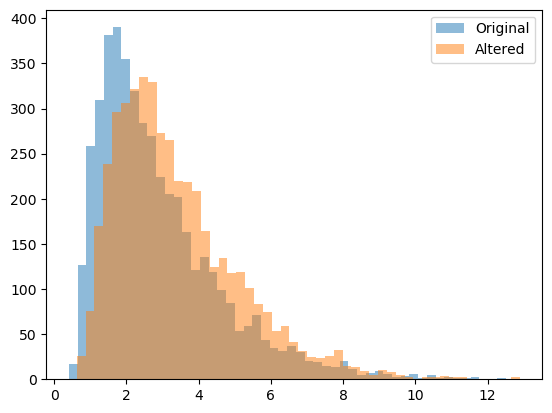

In [6]:
# --- Analysis ---
fused = pd.read_csv('fused.csv')

# Replace NaN values with empty string
fused = fused.fillna('')

print(f"Mean Org.: {fused['temp_match_original'].mean()}")
print(f"Mean Alt.: {fused['temp_match_altered'].mean()}")

improvements = fused[fused['temp_match_altered'] < fused['temp_match_original']]
degradations = fused[fused['temp_match_altered'] > fused['temp_match_original']]

# Figure out how many times the altered temp_match is higher than the original and vice-versa
print(f"Altered worse than original: {len(improvements)}")
print(f"Original worse than altered: {len(degradations)}")

# Create histogram of temp_match_original and temp_match_altered
import matplotlib.pyplot as plt

plt.hist(fused['temp_match_original'], bins=50, alpha=0.5, label='Original')
plt.hist(fused['temp_match_altered'], bins=50, alpha=0.5, label='Altered')
plt.legend(loc='upper right')
plt.show()

In [10]:
improvements['diff'] = improvements['temp_match_original'] - improvements['temp_match_altered']
degradations['diff'] = degradations['temp_match_altered'] - degradations['temp_match_original']

# Sort by diff
improvements = improvements.sort_values(by='diff', ascending=False)
degradations = degradations.sort_values(by='diff', ascending=False)

cprint('Top 10 improvements', 'green', attrs=['bold'])
"""for i in range(10):
    print(colored("Original token: ", 'blue') + improvements['token_original'].iloc[i])
    try:
        print(colored("Added info: ", 'blue') + improvements['token_altered_no_prefix'].iloc[i])
    except:
        print(colored("Added info: ", 'blue') + "-")
    print(colored("Improvement: ", 'blue') + f"{improvements['diff'].iloc[i]}")
    print('\n')"""

for i in range(10):
    print(colored("Original token: ", 'blue') + improvements['token_original'].iloc[i])
    print(colored("Altered token: ", 'blue') + improvements['token_altered'].iloc[i])
    print(colored("Improvement: ", 'blue') + f"{improvements['diff'].iloc[i]}")
    print('\n')


Top 10 improvements
Original token: the sim extend arm out ward then take a sit in a cresscross fashion before stand up again 
Altered token: a person is carefully drink from a cup by raise the cup to their mouth and take a sip 
Improvement: 10.1793922


Original token: a person stand at the bottom edge of the path right in the center with a slight squat raise both arm place them down then raise the right red arm and hold it there for a few second before place it back down 
Altered token: a person stand on one leg in a yoga pose maintain balance and stability 
Improvement: 10.054931499999999


Original token: stickman right hand wave five time with full motion from elbow to hand extension 
Altered token: this person wave widely with his left arm use the arm to make wide wave motion 
Improvement: 8.9629934


Original token: a person quickly pace while look down 
Altered token: the person is make an arm gesture put his arm up into the air Both arm raise upwards simultaneously extend full

In [13]:
cprint('Top 10 degradations', 'red', attrs=['bold'])
"""for i in range(10):
    print(colored("Original token: ", 'blue') + degradations['token_original'].iloc[i])
    try:
        print(colored("Added info: ", 'blue') + degradations['token_altered_no_prefix'].iloc[i])
    except:
        print(colored("Added info: ", 'blue') + "-")
    print('\n')"""
    
for i in range(10):
    print(colored("Original token: ", 'blue') + degradations['token_original'].iloc[i])
    print(colored("Altered token: ", 'blue') + degradations['token_altered'].iloc[i])
    print('\n')

Top 10 degradations
Original token: walk backwards and then stop 
Altered token: a person walk in a clockwise direction by lift and extend their leg while swinge their arm in the same direction 


Original token: a person does the cat walk 
Altered token: a person start to jump while grab something engage in a combination of lift off the ground and hold onto an object for support 


Original token: a person slowly walk forward and return back 
Altered token: a person take a large lateral step to the left side by extend their leg widely while keep the torso upright The arm may swing in response to the movement 


Original token: a man walk slowly forwards 
Altered token: a person squat down to the ground pick up a box then stand back up and place the box on a higher surface by bend at the knee and hip reach down to pick up the box then straighten their body to stand up and finally place the box on 


Original token: a person kick two ball with his left foot the first to his right and th

In [9]:
# Find the most common words in the token_altered_no_prefix column
from collections import Counter

words = []
for i in range(len(fused)):
    words.extend(fused.iloc[i]['token_altered_no_prefix'].split(' '))

counter = Counter(words)
print(counter.most_common(20))

KeyError: 'token_altered_no_prefix'

In [ ]:
keywords = ['leg', 'arm', 'torso', 'knee', 'hip', 'elbow', 'hand', 'forward', 'extend', 'swinge', 'move']

for keyword in keywords:
    print(f"Keyword: {keyword}")
    print(f"Improvements: {improvements['token_altered_no_prefix'].str.contains(keyword).sum()}")
    print(f"Degradations: {degradations['token_altered_no_prefix'].str.contains(keyword).sum()}")
    total_improvement = improvements[improvements['token_altered_no_prefix'].str.contains(keyword)]['diff'].sum()
    total_degradation = degradations[degradations['token_altered_no_prefix'].str.contains(keyword)]['diff'].sum()
    print(f"Total improvement: {total_improvement}")
    print(f"Total degradation: {total_degradation}")
    print('\n')

Keyword: leg
Improvements: 78
Degradations: 93
Total improvement: 119.32579404999998
Total degradation: 111.25171639999998


Keyword: arm
Improvements: 594
Degradations: 779
Total improvement: 746.53197093
Total degradation: 1000.01132355


Keyword: torso
Improvements: 15
Degradations: 49
Total improvement: 25.918384300000003
Total degradation: 75.95771297


Keyword: knee
Improvements: 44
Degradations: 34
Total improvement: 47.29658609999999
Total degradation: 35.38302283


Keyword: hip
Improvements: 22
Degradations: 21
Total improvement: 43.24909949999999
Total degradation: 42.826658699999996


Keyword: elbow
Improvements: 14
Degradations: 14
Total improvement: 26.077541999999998
Total degradation: 16.852620899999998


Keyword: hand
Improvements: 373
Degradations: 442
Total improvement: 424.43251318
Total degradation: 569.82615003


Keyword: forward
Improvements: 492
Degradations: 658
Total improvement: 606.97194056
Total degradation: 955.51651367


Keyword: extend
Improvements: 161
D

In [ ]:
# Get best and worst quantile (10%) based on temp_match from original for both original and altered prompts
original_good = fused[fused['temp_match_original'] < fused['temp_match_original'].quantile(0.1)]
original_bad =  fused[fused['temp_match_original'] > fused['temp_match_original'].quantile(0.9)]
altered_good = fused[fused['temp_match_altered'] < fused['temp_match_original'].quantile(0.1)]
altered_bad =  fused[fused['temp_match_altered'] > fused['temp_match_original'].quantile(0.9)]

cols_to_use = original_good.columns.difference(altered_good.columns) # This is essentially just the index

# We collect 4 classes:
# GG: Original good, Altered good
# GB: Original good, Altered bad
# BG: Original bad, Altered good
# BB: Original bad, Altered bad
GG = pd.merge(original_good, altered_good[cols_to_use], left_index=True, right_index=True, how='inner')
GB = pd.merge(original_good, altered_bad[cols_to_use], left_index=True, right_index=True, how='inner')
BG = pd.merge(original_bad, altered_good[cols_to_use], left_index=True, right_index=True, how='inner')
BB = pd.merge(original_bad, altered_bad[cols_to_use], left_index=True, right_index=True, how='inner')

GG[['token_original', 'token_altered_no_prefix']]

,token_original,token_altered_no_prefix
339,a person jump up and down time,Upper body remain upright
353,a person walk backwards and then stop,
419,a person is walk in a straight line,
432,the person is jump up and down,
506,a person is jump up and down from the ground,
...,...,...
4468,person is walk forward really slowly,
4495,a person walk slowly across something,
4531,a person walk forward then turn and walk back ...,trunk rotate to change direction
4596,a man walk clockwise in a circle repeatedly,
